In [1]:
pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.5 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_squared_error, mean_absolute_error
import dmba

Colab environment detected.


In [3]:
# load data and convert to time series
Amtrak_df = dmba.load_data('Amtrak.csv')
Amtrak_df.head()

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964


In [4]:
# convert the date information to a datetime object
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')

In [5]:
Amtrak_df.head()

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


In [6]:
# convert dataframe column to series (name is used to label the data)
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')

In [7]:
#add a trend: ct= constant and linear trend
ridership_df = tsatools.add_trend(ridership_ts, trend='t')

In [8]:
ridership_df.head(10)

,Ridership,trend
Date,,
1991-01-01,1708.917,1.0
1991-02-01,1620.586,2.0
1991-03-01,1972.715,3.0
1991-04-01,1811.665,4.0
1991-05-01,1974.964,5.0
1991-06-01,1862.356,6.0
1991-07-01,1939.860,7.0
1991-08-01,2013.264,8.0
1991-09-01,1595.657,9.0


In [9]:
nValid = 36
nTrain = len(ridership_ts) - nValid

In [10]:

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

In [11]:
# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
print(ridership_lm.summary())


                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.390
Time:                        06:29:33   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.073     60.206      0.0

In [12]:
predict_df = ridership_lm.predict(valid_df)

#root mean square error
mse = mean_squared_error(valid_df['Ridership'], predict_df)
rmse = np.sqrt(mse)
print(rmse)

239.48625510292553


In [13]:

ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()

predict_df_expo = np.exp(ridership_lm_expo.predict(valid_df))

ridership_lm_expo.summary()

mse = mean_squared_error(valid_df['Ridership'], predict_df_expo)
rmse = np.sqrt(mse)
print(rmse)

247.75504344912892


In [14]:
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()
predict_df_poly = ridership_lm_poly.predict(valid_df)
ridership_lm_poly.summary()

mse = mean_squared_error(valid_df['Ridership'], predict_df_poly)
rmse = np.sqrt(mse)
print(rmse)


179.84942266652334


In [15]:
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()
predict_df_season = ridership_lm_season.predict(valid_df)
ridership_lm_season.summary()


mse = mean_squared_error(valid_df['Ridership'], predict_df_season)
rmse = np.sqrt(mse)
print(rmse)

229.65091956721403


In [16]:

ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()
predict_df_trendseason = ridership_lm_trendseason.predict(valid_df)

print(ridership_lm_trendseason.summary())


mse = mean_squared_error(valid_df['Ridership'], predict_df_trendseason)
rmse = np.sqrt(mse)
print(rmse)

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           3.75e-35
Time:                        06:36:34   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

Smoothing-Moving Average

In [53]:
# centered moving average with window size = 12
ridership_df['CMA_12'] = ridership_df['Ridership'].rolling(12, center=True).mean()

In [17]:
# trailing moving average with window size = 12
ridership_df['TMA_12'] = ridership_df['Ridership'].rolling(12).mean()

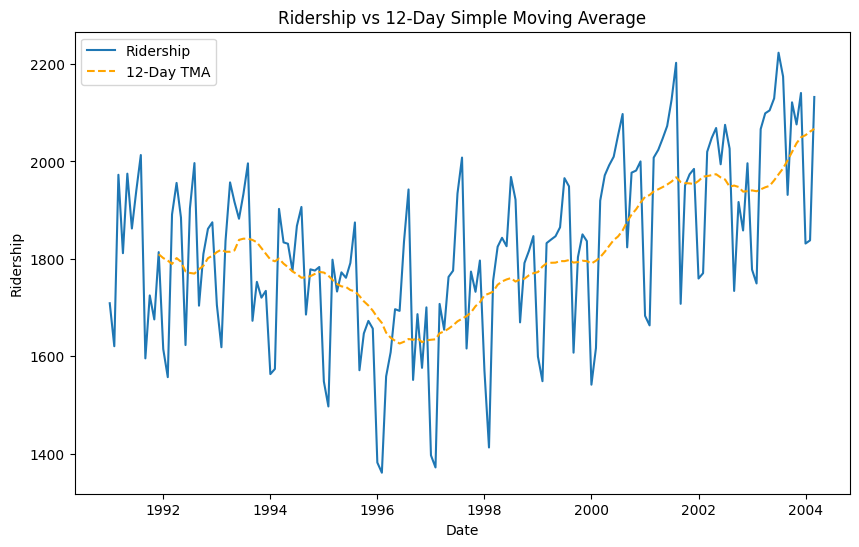

In [18]:
plt.figure(figsize=(10,6))
plt.plot(ridership_df['Ridership'], label='Ridership')
plt.plot(ridership_df['TMA_12'], label='12-Day TMA', linestyle='--', color='orange')
plt.title('Ridership vs 12-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()